# Expected Epidemic Size of Mask Model


## 1. Condition on num of neighbors from lower level

$A_{L, 0}$ := Node v becomes **active** at level L and he **wear** a mask

$A_{L, 1}$ := Node v becomes **active** at level L and he **doesn't wears** a mask




$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 1}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$




## 2. Condition on num of active lower level neighbors

$I_0$ := $I_0$ of $k-1$ lower level neighbors active and wear masks

$I_1$ := $I_1$ of $k-1$ lower level neighbors active and don't wear masks

$P(A_{L, i} | B_k) = \sum_{k_0 = 0}^{k-1}\sum_{k_1 = 0}^{k-1-k_0}P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
k - 1 \\
k_0
\end{array}\right) \left(\begin{array}{c}
k - 1 - k_0 \\
k_1
\end{array}\right) * A_{L-1, 0}^{k_0} * A_{L-1, 1}^{k_1} * (1 - A_{L-1, 0} - A_{L-1, 1})^{(k - 1 - k_0 - k_1)}$

where

$i = 0,1$

## 3.a Condition on the num of infected lower level neighbors *


$X$ := Num of infection received from active lower level neighbors **wearing** masks 

$Y$ := Num of infection received from active lower level neighbors **not wearing** masks 


$Q_1 = T_1 * (1 - m) + T_2 * m$ => Lower level neighbors' avg transmissibility if wear masks

$Q_2 = T_3 * (1 - m) + T_4 * m$ => Lower level neighbors' avg transmissibility if don't wear masks


$X \sim \operatorname{Binomial}\left(k_0, Q_1\right)$

$Y \sim \operatorname{Binomial}\left(k_1, Q_2\right)$


$P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1)=$

$\sum_{x = 0}^{k_0}\sum_{y = 0}^{k_1}\left(\begin{array}{c}
k_0 \\
x
\end{array}\right)  \left(\begin{array}{c}
k_1 \\
y
\end{array}\right) * Q_1^{x} * Q_2^{y} * (1 - Q_1)^{(k_0 -x)} * (1 - Q_2)^{(k_1 - y)} * P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1, X = x, Y = y)$

where

$i = 0,1$



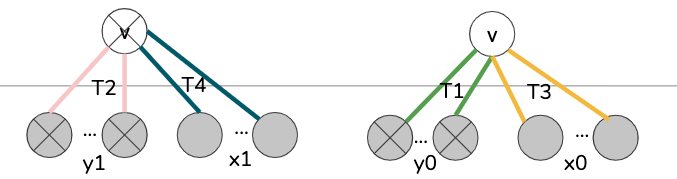

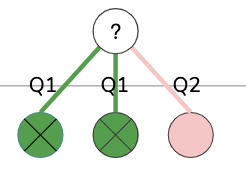


## 4.a $P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1, X = x, Y = y)$ *

Let 
$R := B_k, I_0 = k_0, I_1 = k_1, X = x, Y = y$

### Goal: $P(A_{L, i} | R)$

Recall: $A_{L, 0}$ := Node v becomes **active** at level L and he **doesn't wear** a mask



$M$ := Node v wears a mask

$C$ := Node v becomes active

$A_{L, 1} | R = (C M) | R$

$A_{L, 0} | R = (C\overline M) | R$


(R gives information about the estimated percentage of people who wear masks)

$P((C M) | R) = P(C | R) * P(M)$

$P((C\overline M) | R) = P(C | R) * P(\overline M)$

##### p.s. Notation from Slides Page 85

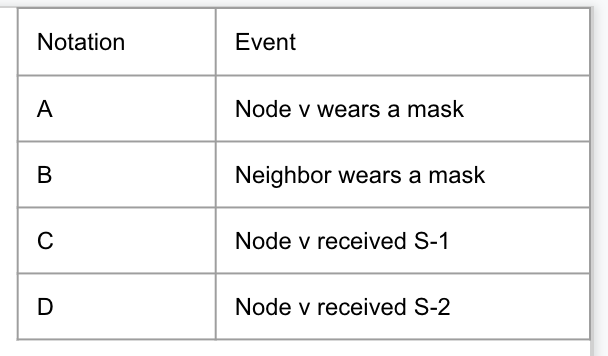 

## 3.b $P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1)$

I can understand that in the paper that we need to specify the num of infections from different strains:

it is becasue we need to know which strain to have if multiple strains infect us together.

But in our case, we don't just have 1 strain. SO as long as one of them infect us, we are infected.

$P(A_{L, i} | B_k, I_0 = k_0, I_1 = k_1)$ = $(1 - (1 - Q_1)^{k_0} * (1 - Q_2)^{k_1}) * m^{(1 - i)} * (1 - m)^i$

In the experiement code, we can still shuffle. But we don't use the strain we get by this shuffling. 

The transmissibility is decided by the edge types in advance. => no relationship with who gives us the infection or what strain we have.

(Paper code, the transmissibility is decided on the previous transmission steps)

| RV/Event | Mask | Mutation  | From which model |
|----------|------|-----------|------|
| $A_{L,0}$ | Node v becomes active \& wears a mask  | $AC$ + $AD$  | Mask model  |   
| $A_{L,1}$ | Node v becomes active \& not wearing a mask  | $\overline AC$ + $\overline AD$  |  Mask model |  
| $R$  | Condition on active neighbors  | An RV to check the only one neigbor's mask (we assume he is active): $B$ | Mask model  |  
| $A_{L,0} | R$  | Node v get infected by anyone \& wears a mask, given active neighbors | $(AC + AD)|B$ | Mask model  | 
| $\mu11$  |   | $P(A | C)$  | Mutation model  |
| $\mu12$  |   | $P(\overline A | C)$  | Mutation model  |  
| $\mu21$  |   | $P(A | D)$  | Mutation model  |
| $\mu22$  |   | $P(\overline A | D)$  | Mutation model  |  
| $A | X = x, Y = y$  |   | $x Cs, y Ds  |  k_0 Bs, k_1 \overline B$  | Mutation model  | 



# Question
1. Prob of emergence
Prob of emergence = 1 - Prob of extinction.

Prob of ext: q = f(q)

====> try solve(), ====> start from 1, 

2. Epidemic Size
$ q_{L + 1} = f(q_L), L \rightarrow \infty$

3. $q_0$ should be started from 0?
====> start from 1, 
4. Where is the threshold to determine the epidemic in the derivation?
====> 5\%
5. Where is the threshold to determine the emergence in the derivation?

====> 200,000 nodes, plot more details around threshold

This time:

1. Does Mask Model need shuffle?
Mask model doesn't need shuffle becuase it doesn't need to decide which strain to get so no need to have the randomness about which strain to have. 

For Mask strain, just do all the ber trials one by one, as long as one guy give me infection I get it.

In [1]:
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson

In [66]:
def nCk(n,k): 
    return int(round(reduce(mul, (float(n-i)/(i+1) for i in range(k)), 1)))

In [67]:
def P_S(x, y, T1, T3):
    res = 1 - ((1 - T1) ** x) * ((1 - T3) ** y)
    assert res >= 0, "P_S should be greater than 0"
    assert res <= 1, "P_S should be less than 1"
    return res

In [68]:
def P_R(x, y, T2, T4):
    res = 1 - ((1 - T2) ** x) * ((1 - T4) ** y)
    assert res >= 0, "P_S should be greater than 0"
    assert res <= 1, "P_S should be less than 1"
    return res

In [69]:
def P_ABCE(P_mask, T_list, x, y):
    p_r = P_R(x, y, T_list[1], T_list[3])
    p_s = P_S(x, y, T_list[0], T_list[2])
    res = p_r * P_mask + p_s * (1 - P_mask)
    assert res >= 0, "P_R should be greater than 0"
    assert res <= 1, "P_R should be less than 1"
    return res

In [70]:
def P_ABC(P_mask, T_list, m, k, A_lower):
    y_range = k - 1 - m
    p_abc = 0
    one_minus_A_lower = 1 - A_lower
    for x in range(m + 1):
        for y in range(y_range + 1):
            p_abce = P_ABCE(P_mask, T_list, x, y)
            p_abc += nCk(m, x) * nCk(y_range, y) * p_abce * \
                     (A_lower ** (x + y)) * \
                     (one_minus_A_lower ** (k - 1 - x - y))
    
    assert p_abc >= 0, "P_ABC should be greater than 0"
    assert p_abc <= 1, "P_ABC should be less than 1"
    return p_abc

In [71]:
def P_AB(P_mask, T_list, k, A_lower):
    one_minus_pmask = 1 - P_mask
    p_ab = 0
    for m in range(k):
        p_c = nCk(k-1, m) * (P_mask ** m) * (one_minus_pmask ** (k - 1 - m))
        p_abc = P_ABC(P_mask, T_list, m, k, A_lower)
        p_ab += p_abc * p_c
    assert p_ab >= 0, "P_AB should be greater than 0"
    assert p_ab <= 1, "P_AB should be less than 1"
    return p_ab

In [96]:
def generate_degree_list(mean_degree, nodeN):
    degree_max = nodeN
    
    p_k = dict() # k: degree, v: prob
    
    for degree in range(degree_max):
        p_k[degree] = poisson.pmf(degree, mean_degree)
        if p_k[degree] < 10 ** (- math.log10(nodeN)):
            break
    return p_k, degree

In [100]:
def P_A(mean_degree, nodeN, P_mask, T_list, A_lower):
    P_k_dict, k_max = generate_degree_list(mean_degree, nodeN)
    pa_L = 0
    for k in range(1, k_max):
        if k not in P_k_dict.keys():
            p_k = 0
        else:
            p_k = P_k_dict[k]
        p_b = k * p_k / mean_degree
        p_ab = P_AB(P_mask, T_list, k, A_lower)
        pa_L += p_ab * p_b
        
        assert p_ab >= 0, "P_AB should be greater than 0"
        assert p_ab < 1, "P_AB should be less than 1"
    return pa_L

In [101]:
def get_ProbEmergence(mean_degree, nodeN, P_mask, T_list, A_lower, converg_thr):
    ### Solve f(q) = q to get Prob of EXT. ###
    p_a_L = P_A(mean_degree, nodeN, P_mask, T_list, A_lower)

    while abs(A_lower - p_a_L) > converg_thr:
        A_lower = p_a_L
        p_a_L = P_A(mean_degree, nodeN, P_mask, T_list, p_a_L)
    return p_a_L

In [102]:
def get_EpidemicSize(mean_degree, nodeN, P_mask, T_list, A_lower):
    ### Get PA when level -> +inf ###
    inf = math.log2(nodeN) # max level of a tree i
    p_a_L = A_lower
    for i in range(int(inf)):
        print(i)
        p_a_L = P_A(mean_degree, nodeN, P_mask, T_list, p_a_L)
    return p_a_L

In [105]:
# Parameters setup
init_A_lower = 0.00001
converg_thr = 0.00000001
nodeN = 10000
P_mask = 0.6
T_list = [0.00480, 0.03200, 0.32000, 0.04800]
mean_degree_list = np.linspace(0, 10, 50)

Text(0.5, 1.0, 'Theoratical Prob of Emergence for Mask Model')

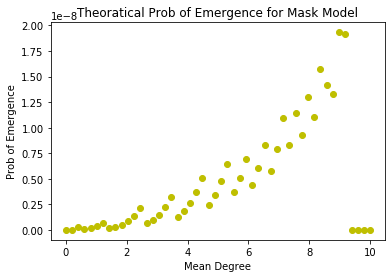

In [106]:
prob_emergence_list = []

for mean_degree in mean_degree_list:
    prob_emergence_list.append(get_ProbEmergence(mean_degree, nodeN, P_mask, T_list, init_A_lower, converg_thr))
    
plt.figure()
plt.plot(mean_degree_list, prob_emergence_list, 'yo')
plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Theoratical Prob of Emergence for Mask Model"
plt.title(title)

Mean degree: 0.0
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 0.20408163265306123
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 0.40816326530612246
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 0.6122448979591837
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 0.8163265306122449
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 1.0204081632653061
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 1.2244897959183674
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 1.4285714285714286
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 1.6326530612244898
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 1.836734693877551
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 2.0408163265306123
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 2.2448979591836737
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 2.4489795918367347
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 2.6530612244897958
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 2.857142857142857
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 3.0612244897959187
0
1
2
3
4
5
6
7
8
9
10
11
12
Mean degree: 3.2653061224489797
0
1
2
3

Text(0.5, 1.0, 'Theoratical Infection Fraction for Mask Model')

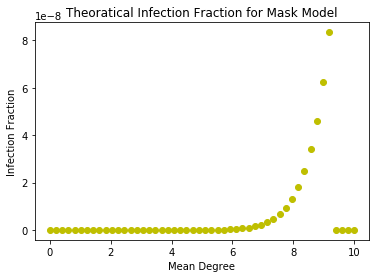

In [107]:
infection_size = []

for mean_degree in mean_degree_list:
    print("Mean degree:", mean_degree)
    infection_size.append(get_EpidemicSize(mean_degree, nodeN, P_mask, T_list, init_A_lower))

plt.figure()
plt.plot(mean_degree_list, infection_size, 'yo')
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Theoratical Infection Fraction for Mask Model"
plt.title(title)